# Pytorch
Ejemplo de clasificador con Pytorch, comentado en español. 

El cuaderno de Jupyter se ha desarrollado con Visual Code y puedes encontrar el código en https://github.com/josegemez/pytorch_mnist 

Se ha desarrollado en python 3.10.4 

## Import
Con las primeras lineas vamos a importar los paquetes que básicos de Pytorch. 

In [1]:
import torch
import torchvision

## Variables Generales

In [2]:
batch_size_train = 128
batch_size_test = 128

## Transformaciones 

In [3]:
transforms=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])

## Dataset 

In [4]:
dataset_mnist = torchvision.datasets.MNIST('/files/', train=True, download=True, transform=transforms)                    

In [5]:
train_size = int(0.8 * len(dataset_mnist))
test_size = len(dataset_mnist) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_mnist, [train_size, test_size])

## Dataloader

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,  batch_size=batch_size_train, shuffle=True,num_workers=5,pin_memory=True)

Vamos a ver que "pinta" tiene cada elemento del cargador

In [7]:
x, y = next(iter(train_loader)) #asignamos el primer batch a las variables x e y. La variable X contrendra las imagenes e y contrendra las etiquetas

x es un batch, por lo que la primera dimensión coincidira con el batch size 

In [8]:
from matplotlib.pyplot import imshow

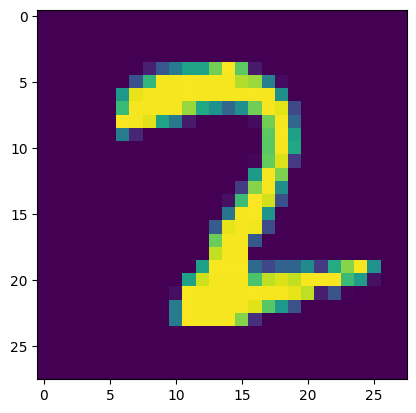

In [9]:
imshow(x[0].view(28,28).numpy()); # transformamos el primer elemento del batch una matriz de numpy y mostramos con matplotlib

In [10]:
y

tensor([2, 8, 2, 6, 2, 1, 6, 0, 6, 3, 8, 1, 9, 9, 4, 8, 9, 2, 9, 2, 9, 0, 0, 0,
        3, 0, 4, 8, 3, 3, 8, 9, 8, 4, 5, 4, 1, 4, 7, 9, 4, 3, 6, 8, 7, 4, 1, 8,
        7, 6, 0, 3, 9, 3, 5, 2, 3, 4, 5, 5, 1, 1, 3, 2, 6, 7, 7, 1, 3, 9, 7, 0,
        7, 0, 7, 1, 6, 7, 7, 0, 0, 9, 0, 4, 5, 1, 2, 8, 7, 4, 6, 1, 9, 6, 8, 6,
        1, 8, 6, 9, 6, 8, 1, 7, 1, 9, 1, 1, 9, 1, 9, 9, 8, 3, 5, 9, 1, 4, 6, 6,
        0, 4, 3, 5, 8, 0, 2, 4])

## Dataset Test

In [11]:
test_loader = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size_test, shuffle=True, num_workers=5,pin_memory=True)              

Ya tenemos los datos preparados, ahora vamos a crear la red

In [12]:
learning_rate   =   0.01
momentum   =   0.5
n_epochs = 20


In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np

## MLP

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        n_hidden1 = 128
        n_hidden2 = 64
        self.fc1 = nn.Linear(28*28,n_hidden1) #capa "fuly connect" entrada 28*28 (tamaño de la imagen) 50 neuronas
        self.fc1_drop = nn.Dropout(0.2) #dropout (regularizacion) 20% 
        self.fc2 = nn.Linear(n_hidden1, n_hidden2) #capa fully connect 50 neuronas 
        self.fc2_drop = nn.Dropout(0.2) #dropout (regularizacion) 20%
        self.fc3 = nn.Linear(n_hidden2, 10) #capa de salida numero de salida igual al de etiquetas

    def forward(self, x):
        x = x.view(-1, 28*28) #cambia la forma del tensor, -1 para quitar la dimensiones anteriores y dejarlo todo en una vector de 256 elementos
        x = F.relu(self.fc1(x)) #capa fully connect y luego activacion relu
        x = self.fc1_drop(x) #dropout (regularizacion)
        x = F.relu(self.fc2(x)) #capa fully connect y luego activacion relu
        x = self.fc2_drop(x) #dropout (regularizacion)
        return F.log_softmax(self.fc3(x), dim=1) #soft max (estimacion estadistica 0-1 de la probabildad de que sea de un etiqueta u otra)

## Convolutional

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [16]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')
device

device(type='cuda')

In [17]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
criterion =  nn.CrossEntropyLoss().to(device)


In [18]:
model

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

for epoch in range(n_epochs):
  epoch_train_loss = []
  epoch_train_acc = []
  epoch_test_loss = []
  epoch_test_acc = []
  running_loss = 0.
  model.train() #modelo en modo entranamiento
   #perdida de la primera epoca
  with tqdm(train_loader, unit='batch') as tepoch: #tqdm para ver la barra de progreso por batch
    for data, target in tepoch: #en cada batch data la imagen de 28x28 y target la prediccion
      model.train(True)
      tepoch.set_description(f'Epoch {epoch}') #texto al final de la barra de progreso
      data, target = data.to(device=device, non_blocking=True), target.to(device=device, non_blocking=True).long() #se pasan lo datos y las etiquetas al "device"
      optimizer.zero_grad() #se inicializan los gradientes
      output = model(data) #se realiza la predicción propagación haciea adelante
      loss = F.nll_loss(output, target) #se calcula la funcion de perdida entre los valores predichos (output) y los valores reales (target)
      pred = output.data.max(1, keepdim=True)[1] #valores predichos
      correct = pred.eq(target.data.view_as(pred)).sum()
      accuracy = correct.item()/batch_size_train
      epoch_train_acc.append(accuracy)
      epoch_train_loss.append(loss.cpu().item()) #se guardan el valor de la perdida
      loss.backward() #se realiza la retropropagación 
      optimizer.step() #se realiza un paso adelante con el learning rate y el gradiente calculado
      running_loss += loss.item()
      model.train(False)
      i, datum = next(enumerate(test_loader))
      data, target = datum
      data, target = data.to(device=device, non_blocking=True), target.to(device=device, non_blocking=True).long() #se pasan lo datos y las etiquetas al "device"
      output = model(data) #se realiza la predicción propagación haciea adelante
      t_loss = F.nll_loss(output, target) #se calcula la funcion de perdida entre los valores predichos (output) y los valores reales (target)    
      pred = output.data.max(1, keepdim=True)[1] #valores predichos
      correct = pred.eq(target.data.view_as(pred)).sum()    
      test_accuracy = correct.item()/batch_size_test
      epoch_test_acc.append(test_accuracy)
      epoch_test_loss.append(t_loss.cpu().item()) #se guardan el valor de la perdida
      train_loss.append(np.mean(epoch_train_loss))
      test_loss.append(np.mean(epoch_test_loss))
      train_acc.append(np.mean(epoch_train_acc))
      test_acc.append(np.mean(epoch_test_acc))
      if i % 1000 == 999:
        print(f'Lost train {running_loss/1000}')
  scheduler.step() #se realiza un paso para cambiar el learning rate
  print(f'Epoch {epoch}: Train loss {np.mean(epoch_train_loss)} Test loss {np.mean(epoch_test_loss)} Train accuracy {np.mean(epoch_train_acc)} Test accuracy {np.mean(epoch_test_acc)}')
  


In [19]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=20, device='cuda'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parametros
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Funcion de perdida (e.g. nn.CrossEntropyLoss())
    train_dl : 
        Dataloader para los datos de entrenamiento.
    val_dl :
        Dataloader para los datos de validacion.
    epochs : int
        Numero de epocas
    device : string
        'cuda' para entrenamiento en gpu y 'cpu' para entrenamiento en cpu

    Retorno
    -------
    Diccionario
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    history = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(epochs):

        # --- Entrenamiento en los datos de entrenamientos -----------------------------
        model.train() #modelo en forma de entrenamiento    
        train_loss         = 0.0 #perdida inicializada en cero
        num_train_correct  = 0 #numero de elementos donde la prediccion coincide con la etiqueta "true positive"
        num_train_examples = 0 #inicializa el numero de elementos sobre los que se ha realizado entrenamiento

        for batch in train_dl:

            optimizer.zero_grad() #pone los gradientes a cero

            x    = batch[0].to(device) #datos al dispositivo (cpu o gpu)
            y    = batch[1].to(device) #idem
            yhat = model(x) # y predichos 
            loss = loss_fn(yhat, y) #calcula la perdida entre los "y predichos" y los "y etiquetas"

            loss.backward() #retropropagación
            optimizer.step() #se mueve el gradiente un paso (learning rate por el gradiente negativo)

            train_loss         += loss.data.item() * x.size(0) 
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item() #compureba los elementos correctos
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- Evaluacion en los datos de test -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
              (epoch+1, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

In [20]:
history = train(model,optimizer,criterion, train_loader, test_loader, n_epochs, 'cuda')

train() called: model=Net, opt=SGD(lr=0.010000), epochs=20, device=cuda

Epoch   1/ 20, train loss:  1.36, train acc:  0.53, val loss:  0.35, val acc:  0.91
Epoch   2/ 20, train loss:  0.56, train acc:  0.83, val loss:  0.22, val acc:  0.94
Epoch   3/ 20, train loss:  0.43, train acc:  0.87, val loss:  0.17, val acc:  0.95
Epoch   4/ 20, train loss:  0.37, train acc:  0.89, val loss:  0.14, val acc:  0.96
Epoch   5/ 20, train loss:  0.33, train acc:  0.90, val loss:  0.13, val acc:  0.96
Epoch   6/ 20, train loss:  0.30, train acc:  0.91, val loss:  0.12, val acc:  0.96
Epoch   7/ 20, train loss:  0.28, train acc:  0.92, val loss:  0.11, val acc:  0.97
Epoch   8/ 20, train loss:  0.26, train acc:  0.92, val loss:  0.10, val acc:  0.97
Epoch   9/ 20, train loss:  0.25, train acc:  0.93, val loss:  0.10, val acc:  0.97
Epoch  10/ 20, train loss:  0.24, train acc:  0.93, val loss:  0.09, val acc:  0.97
Epoch  11/ 20, train loss:  0.23, train acc:  0.93, val loss:  0.09, val acc:  0.97
Epo

In [21]:
torch.save(model.state_dict(), 'results/model.pth')
torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [ ]:
model.load_state_dict(torch.load('results/model.pth'))
model.eval()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure()
epochs = len(train_loss)
plt.plot(range(len(history['loss'])), history['loss'], 'bo', label='Training loss')
plt.plot(range(len(history['val_loss'])), history['val_loss'], c="red",label='Val loss')
plt.title('Training and test loss')
plt.legend()
plt.ylim([0, 3])


In [ ]:
fig = plt.figure()
epochs = len(train_loss)
plt.plot(range(len(history['acc'])), history['acc'], 'bo', label='Training acc')
plt.plot(range(len(history['val_acc'])), history['val_acc'], c="red",label='Val acc')
plt.title('Training and test acc')
plt.legend()
plt.ylim([0, 1])